In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Get file from NSRDB

Following examples from notebooks here: https://github.com/NREL/hsds-examples/blob/master/notebooks/03_NSRDB_introduction.ipynb

For more information on what data is available from the files, see the NSRDB documentation @ NREL: https://developer.nrel.gov/docs/

Actual documentation on how to use the h5py dataset object: https://docs.h5py.org/en/stable/quick.html#quick


For this to work you must first install h5pyd:

pip install --user h5pyd
Next you'll need to configure HSDS:

    `hsconfigure`
and enter at the prompt:

    hs_endpoint = https://developer.nrel.gov/api/hsds
    hs_username = None
    hs_password = None
        hs_api_key = ul1bgjdq34XTFiAN4rOh8eadBuJhUtsaEFMyWoJr
    The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/

You can also add the above contents to a configuration file at ~/.hscfg

Or they can be passed in like as we've done below.

In [17]:
# Open the desired year of nsrdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/nsrdb/v3/nsrdb_2008.h5", 'r', 'https://developer.nrel.gov/api/hsds', None, None, None, 'ul1bgjdq34XTFiAN4rOh8eadBuJhUtsaEFMyWoJr')

In [3]:
list(f.attrs)  # list attributes belonging to the root group

['Version']

In [4]:
f.attrs['Version']   # attributes can be used to provide desriptions of the content

'3.0.6'

## Data Sets

In [5]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_press_acha',
 'cloud_type',
 'coordinates',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [18]:
# Full resolution subset of California
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
70276,32.529999,-117.099998,55.062500,-8,b'United States',b'California',b'San Diego',b'None',32326,130
70588,32.570000,-117.099998,7.100000,-8,b'United States',b'California',b'San Diego',b'Tijuana',27971,190
70589,32.570000,-117.059998,24.920000,-8,b'United States',b'California',b'San Diego',b'Tijuana',51608,190
70590,32.570000,-117.019997,96.599998,-8,b'United States',b'California',b'San Diego',b'Tijuana',15236,110
70591,32.570000,-116.980003,140.600006,-8,b'United States',b'California',b'San Diego',b'Tijuana',2949,130


In [19]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2008-01-01 00:00:00', '2008-01-01 00:30:00',
               '2008-01-01 01:00:00', '2008-01-01 01:30:00',
               '2008-01-01 02:00:00', '2008-01-01 02:30:00',
               '2008-01-01 03:00:00', '2008-01-01 03:30:00',
               '2008-01-01 04:00:00', '2008-01-01 04:30:00',
               ...
               '2008-12-31 19:00:00', '2008-12-31 19:30:00',
               '2008-12-31 20:00:00', '2008-12-31 20:30:00',
               '2008-12-31 21:00:00', '2008-12-31 21:30:00',
               '2008-12-31 22:00:00', '2008-12-31 22:30:00',
               '2008-12-31 23:00:00', '2008-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17568, freq=None)

In [42]:
condition = (time_index == '2008-01-01 12:00:00')
timestep = np.where(condition)[0][0]
timestep

24

In [13]:
# geolocation coordinates
coordinates_dset = f['coordinates']

# y axis
global_horizontal_irradiance_dset = f['ghi']

# x axes
air_temperature_dset = f['air_temperature']
relative_humidity_dset = f['relative_humidity']
cloud_optical_depth_dset = f['cld_opd_dcomp']
cloud_effective_radius_dset = f['cld_reff_dcomp']
cloud_type_dset = f['cloud_type']

In [43]:
%time data = global_horizontal_irradiance_dset[timestep][CA.index]  # full-resolution subset

OSError: Error retrieving data: None

In [16]:
global_horizontal_irradiance_dset.shape

(17520, 2018392)

In [ ]:
# Full resolution subset of California
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

Index([ 70276,  70588,  70589,  70590,  70591,  70592,  70593,  70594,  70595,
        70596,
       ...
       172682, 172683, 172684, 172685, 172686, 172687, 172688, 172689, 172690,
       172691],
      dtype='int64', length=26010)

KeyboardInterrupt: 

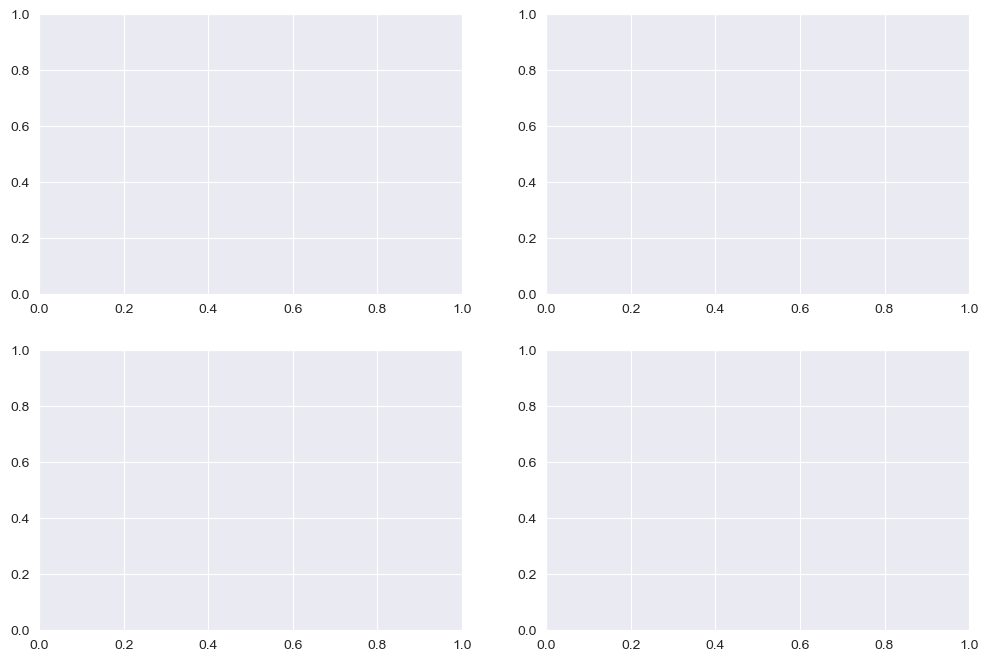

In [11]:
# Plotting the data
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1 - Global Horizontal Irradiance vs. Air Temperature
axs[0, 0].scatter(air_temperature_dset, global_horizontal_irradiance_dset, color='blue', alpha=0.5)
axs[0, 0].set_xlabel('Air Temperature')
axs[0, 0].set_ylabel('Global Horizontal Irradiance')

# Plot 2 - Global Horizontal Irradiance vs. Relative Humidity
axs[0, 1].scatter(relative_humidity_dset, global_horizontal_irradiance_dset, color='green', alpha=0.5)
axs[0, 1].set_xlabel('Relative Humidity')
axs[0, 1].set_ylabel('Global Horizontal Irradiance')

# Plot 3 - Cloud Optical Depth vs. Cloud Effective Radius
axs[1, 0].scatter(cloud_optical_depth_dset, cloud_effective_radius_dset, color='red', alpha=0.5)
axs[1, 0].set_xlabel('Cloud Optical Depth')
axs[1, 0].set_ylabel('Cloud Effective Radius')

# Plot 4 - Cloud Type Distribution
cloud_type_counts = cloud_type_dset.value_counts()
axs[1, 1].bar(cloud_type_counts.index, cloud_type_counts.values, color='purple', alpha=0.5)
axs[1, 1].set_xlabel('Cloud Type')
axs[1, 1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()